# TM10007 Assignment Head and Neck cancer Radiomics

Marie-Claire Doornbos ()
Julia Holdorp (4561651)
Quinten Mank (4336615)
Ylva Weeda (4556038)

 

In [17]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

## Importing Modules

In [18]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import LeaveOneOut, RepeatedStratifiedKFold, StratifiedKFold 
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import auc, roc_curve, accuracy_score, confusion_matrix, roc_auc_score
from scipy import interp
from scipy.stats import randint
from pprint import pprint
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
import seaborn as sns


## 1. Data and preprocessing
The Head and Neck cancer dataset is loaded into the script. If the dataset contains any missing values or NaN, the missing value is replaced with the mean of the feature in question. Eventually, the data is split into feature values and labels (high risk (1) or low risk (0)). The amount of high-risk and low-risk patients is printed as an output. 


1.1 Load data

In [19]:

from hn.load_data import load_data

def load_check_data():
    '''
    Check if the datafile exists and is valid before reading
    '''
    # Check whether datafile exists
    try:
        data = load_data()
        print(f'The number of samples: {len(data.index)}')
        print(f'The number of columns: {len(data.columns)}')
    except FileNotFoundError:
        return print("The csv datafile does not exist"), sys.exit()
    except pd.errors.ParserError:
        return print('The csv datafile is not a proper csv format.'
                     'Please provide a data file in csv format.'), sys.exit()
    # Check whether data is missing.
    # If any datapoints are missing or NaN, these empty cells are replaced with the average 
    # of that feature.
    if data.isnull().values.any():
        column_mean = data.mean()
        data = data.fillna(column_mean)
        print('In the csv data file, some values are missing or NaN.'
              ' These missing values are replaced by the mean of that feature.')
    return data
data = load_check_data()

The number of samples: 113
The number of columns: 160


1.2 Extract feature values and labels

In [20]:
# Features from data
features = data.loc[:, data.columns != 'label'].values

# Labels from data
labels = data.loc[:,['label']].values
#low risk patients receive the label 0 and high risk the label 1
labels = [item if item!='T12' else 0 for item in labels]
labels = [item if item!='T34' else 1 for item in labels]
labels = np.array(labels)
#number of high and low risk patients is printed to the terminal
print(f'Number of high risk patients: {np.count_nonzero(labels)}') 
print(f'Number of low risk patients: {len(labels) - np.count_nonzero(labels)}')

Number of high risk patients: 55
Number of low risk patients: 58


1.3 Splitting the data in training and test

In [21]:
def split_sets(x, y):
    """
    Splits the features and labels into a training set (80%) and test set (20%)
    """
    #use repeated stratified KFold
    crss_val = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=None)
    
    #splitting data into test and training set
    for train_index, test_index in crss_val.split(x, y):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

    #scale the data by fitting on the training set and transforming the test set
        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

        return x_train, x_test, y_train, y_test    

x_train, x_test, y_train, y_test = split_sets(features, labels)


In [22]:
#%% Apply scaling
def scale_data(x, y):
    """Scale data with Standard scaler"""

    scaler = StandardScaler()
    x_train = scaler.fit_transform(x)
    x_test = scaler.transform(y)
    return x_train, x_test

# 2. Feature selection
Two different feature selection/extraction tools will be used. Firstly, least absolute shrinkage and selection operator (LASSO) will be executed to find the most distinctive and informative features for analysis. Later on, a principal component analysis (PCA) is executed while training the model. The amount of principal components were calculated beforehand. In the end, the two different methods will be compared to see which method works best!  




2.1 LASSO 

In [24]:
def lasso_data(x1, y , x2, data):
    """
    Apply L1 regularization with alpha = 0.035 to data
    """
    numerics = ['int16','int32','int64','float16','float32','float64']
    numerical_vars = list(data.select_dtypes(include=numerics).columns)
    data1 = data[numerical_vars]
    lasso = SelectFromModel(estimator=Lasso(alpha=0.0335))
    lasso.fit((pd.DataFrame(x1).fillna(0)),y) 
    lasso.get_support()
    selected_feat = data1.columns[(lasso.get_support())]    
    print('total features: {}'.format((x1.shape[1])))
    print('features with coefficients shrank to zero: {}'.format(np.sum(lasso.estimator_.coef_ == 0)))    
    removed_feats = [(lasso.estimator_.coef_ == 0).ravel().tolist()]
    x_train = lasso.transform(pd.DataFrame(x1).fillna(0))
    x_test = lasso.transform(pd.DataFrame(x2).fillna(0))
    return x_train, x_test


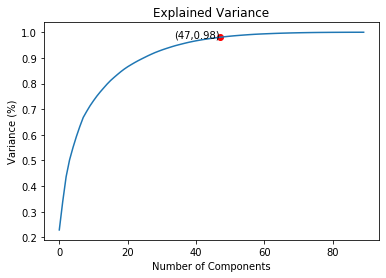

In [25]:
#Number of components vs. Variance. For determination of principal components
#Only computed on scaled training data! 
pca = PCA().fit(x_train)
plt.figure()
plt.scatter(47, 0.98, color='r')
plt.text(47, 0.98, '(47,0.98)', horizontalalignment='right')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') 
plt.title('Explained Variance')
plt.show()
# 47 components for principal component analysis 

#%% Apply PCA
def pca_data(x,y):
    """Apply PCA with 47 components to data"""

    pca = PCA(n_components=47)
    pca.fit(x)
    x_train = pca.transform(x)
    x_test = pca.transform(y)
    return x_train, x_test

# 3. Hyperparameters optimalization and validation
In this part, the data is seperated into a training and a test set. A standard scaler is used to standardize the training set. The training set is fitted and transformed, while the test set is only transformed. (never touch your test set!!) The following classifiers will be used: Logistic Regression, KNN, Random Forest and SVM. In order to find the optimal hyperparameters, a random grid search is executed. The optimal parameters are printed to the terminal and are used for validation. Two different validation methods were used: Leave one out cross validation and repeated KFold cross validation (5 folds and .. repeats). Inside this cross validation, the training set is once again splitted into a training set and a validation set. The performance is determined by the accuracy, sensitivity, specificity and auc. Also, ROC plots are plotted for the different classifiers.  
- ook nog even de learning curve in verwerken! 

3.1 Hyperparameters optimalization and evaluation

3.2 Learning curve

3.3 Leave one Out cross validation on training and validation set - PCA
- Sensitivity, specificity, auc en accuracy even fixen in 1 boxplot
- Alle ROC's in 1 plot ipv los
 

3.4 Repeated KFold cross validation on training and validation set - PCA
- ROC's in 1 grafiek
- boxplots in 1 plot
- titels van de ROC curves aanpassen

3.5 Repeated KFold cross validation on training and validation set - LASSO

3.6 LASSO vs. PCA
- Analyse whether LASSO or PCA works better! 

3.5 Hyperparameters optimalisation vs. no optimalisation
- Analyse whether the hyperparameter optimalisation works better! 

## 6. Evaluation
To evaluate the machine learning algoritm for the prediction of the T-score in head and neck cancer patients, different outcome measures are used. The area under the ROC curve is plotted and also accuracy, sensitivity and specificity are computed using the confusion matrix. The evalution is only executed on the test set to see whether an accuracy of 70% is achieved or not. 

--> box plots


In [26]:
def performance(model, x, y):
    """ Get Performances on test set"""

    base_fpr = np.linspace(0, 1, 101)

    prediction = model.predict(x_test)
    performance_scores = pd.DataFrame()
    auc_scores.append(roc_auc_score(y_test, prediction))
    conf_mat = confusion_matrix(y_test, prediction)
    total = sum(sum(conf_mat))
    accuracies.append((conf_mat[0, 0]+conf_mat[1, 1])/total)
    sensitivities.append(conf_mat[0, 0]/(conf_mat[0, 0]+conf_mat[0, 1]))
    specificities.append(conf_mat[1, 1]/(conf_mat[1, 0]+conf_mat[1, 1]))
    performance_scores['Accuracy'] = accuracies
    performance_scores['AUC'] = auc_scores
    performance_scores['Sensitivity'] = sensitivities
    performance_scores['Specificity'] = specificities

    predicted_probas = model.predict_proba(x_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, predicted_probas)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)

    return performance_scores, tprs, aucs

def plot_ROC(tprs, aucs, name):
    base_fpr = np.linspace(0, 1, 101)

    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)

    mean_auc = auc(base_fpr, mean_tprs)
    std_auc = np.std(aucs)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std
    plt.figure(figsize=(12, 8))
    plt.plot(base_fpr, mean_tprs, 'c', alpha=0.8, label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='c', alpha=0.2)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=0.8)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc="lower right")
    plt.title(f'Receiver operating characteristic (ROC) curve {name}')
    plt.grid()
    plt.show()

    return

def create_boxplot(performance_clf, names):
    
    data1 = pd.DataFrame(performance_clf[0], columns=['Accuracy', 'AUC', 'Sensitivity', 'Specificity']).assign(Location=1)
    data2 = pd.DataFrame(performance_clf[1], columns=['Accuracy', 'AUC', 'Sensitivity', 'Specificity']).assign(Location=2)
    data3 = pd.DataFrame(performance_clf[2], columns=['Accuracy', 'AUC', 'Sensitivity', 'Specificity']).assign(Location=3)
    data4 = pd.DataFrame(performance_clf[3], columns=['Accuracy', 'AUC', 'Sensitivity', 'Specificity']).assign(Location=4)

    cdf = pd.concat([data1, data2, data3, data4])
    mdf = pd.melt(cdf, id_vars=['Location'], var_name=['Index'])

    ax = sns.boxplot(x="Location", y="value", hue="Index", data=mdf)    
    plt.xticks([0, 1, 2, 3], names)
    ax.set_xlabel('Classifier')
    ax.set_ylabel('Performance')
    plt.show()
    
    return

def evaluate_hyperparameters(x, y):
    """Evaluate Hyperparameters"""
    
    fit_models, models = get_hyperparameters(x, y)
    for fit_model, model in zip(fit_models, models):
        parameters = fit_model.best_estimator_.get_params()
        best_score = fit_model.best_score_
        print(f'Best score classifier = {best_score}')
        print(f'For model with hyperparameters: {model}')
    
#evaluate_hyperparameters(x_train, y_train)


In [15]:
# Classifier Pipeline PCA

clsfs = [LogisticRegression(), KNeighborsClassifier(), RandomForestClassifier(bootstrap=True, random_state=None), SVC(probability=True)]
names = ['Logistic Regression', 'kNN', 'Random Forest', 'SVM']
param_distributions = [{'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                        'max_iter': randint(1, 100)}, {'leaf_size': randint(1, 50),
                        'n_neighbors': randint(1, 20), 'p': [1, 2]}, {'n_estimators': randint(1, 500),
                        'max_features': randint(1, 30), 'max_depth': randint(1, 20),
                        'min_samples_leaf': randint(1, 20)}, {'C': randint(0.1, 100),
                        'gamma': ['auto', 'scale'], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}]

performance_clf = []

for clf, name, param_dist in zip(clsfs, names, param_distributions):
    accuracies = []
    auc_scores = []
    specificities = []
    sensitivities = []
    tprs = []
    aucs = []
    base_fpr = np.linspace(0, 1, 101)
    crss_val = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=None) 
    for train_index, test_index in crss_val.split(features, labels):
        x_train, x_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        
        # Scale data with Standard Scalar
        x_train, x_test = scale_data(x_train, x_test)

        # Apply PCA to data
        x_train, x_test = pca_data(x_train, x_test)

        # RandomSearch for optimalization Hyperparameters
        random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=5, cv=5, scoring='accuracy', n_jobs=-1, error_score=0)
        model = random_search.fit(x_train, y_train)
        model = model.best_estimator_
        base_model = clf.fit(x_train, y_train)
        #models.append(model)

        # Evaluate performance on validation set
        scores = cross_val_score(model, x_train, y_train, cv=5)
        pprint(scores)
        pprint(scores.mean())

        # Evaluate performance Hyperparameters on test set
        baseline_performance, tprs, aucs = performance(base_model, x_test, y_test)
        performance_scores, tprs, aucs = performance(model, x_test, y_test)
        base_accuracy = baseline_performance['Accuracy'].mean()
        random_accuracy = performance_scores['Accuracy'].mean()
        
        pprint(f'Performance {name} Classifier at baseline:')
        pprint(f'{base_accuracy}')
        pprint(f'Performance {name} Classifier with Hyperparameters:')
        pprint(f'{random_accuracy}')
        pprint(f'Improvement of {100 * (random_accuracy - base_accuracy) / base_accuracy}%')

    performance_scores.loc['mean'] = performance_scores.mean()
    print(f'Performance {name} Classifier:')
    print(f'{performance_scores}')
    
    # Plot ROC curves
    plot_ROC(tprs, aucs, name)

    performance_clf.append(performance_scores)

# Create boxplot
create_boxplot(performance_clf, names)


NameError: name 'pca_data' is not defined

In [33]:
# Classifier Pipeline Lasso

clsfs = [LogisticRegression(), KNeighborsClassifier(), RandomForestClassifier(bootstrap=True, random_state=None), SVC(probability=True, max_iter=10**6)]
names = ['Logistic Regression', 'kNN', 'Random Forest', 'SVM']
param_distributions = [{'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                        'max_iter': randint(1, 100)}, {'leaf_size': randint(1, 50),
                        'n_neighbors': randint(1, 20), 'p': [1, 2]}, {'n_estimators': randint(1, 500),
                        'max_features': randint(1, 30), 'max_depth': randint(1, 20),
                        'min_samples_leaf': randint(1, 20)}, {'C': randint(0.1, 100),
                        'gamma': ['auto', 'scale'], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}]

performance_clf = []

for clf, name, param_dist in zip(clsfs, names, param_distributions):
    accuracies = []
    auc_scores = []
    specificities = []
    sensitivities = []
    tprs = []
    aucs = []
    base_fpr = np.linspace(0, 1, 101)
    crss_val = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=None) 
    for train_index, test_index in crss_val.split(features, labels):
        x_train, x_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        
        # Scale data with Standard Scalar
        x_train, x_test = scale_data(x_train, x_test)

        # Apply PCA to data
        x_train, x_test = lasso_data(x_train, y_train, x_test, data)

        # RandomSearch for optimalization Hyperparameters
        random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=5, cv=5, scoring='accuracy', n_jobs=-1)
        model = random_search.fit(x_train, y_train)
        model = model.best_estimator_
        #models.append(model)
        
        # Evaluate performance on test data    
        baseline_performance, tprs, aucs = performance(base_model, x_test, y_test)
        performance_scores, tprs, aucs = performance(model, x_test, y_test)
        base_accuracy = baseline_performance['Accuracy'].mean()
        random_accuracy = performance_scores['Accuracy'].mean()
        
        pprint(f'Performance {name} Classifier at baseline:')
        pprint(f'{base_accuracy}')
        pprint(f'Performance {name} Classifier with Hyperparameters:')
        pprint(f'{random_accuracy}')
        pprint(f'Improvement of {100 * (random_accuracy - base_accuracy) / base_accuracy}%')

    # Plot ROC curves
    plot_ROC(tprs, aucs, name)

    performance_clf.append(performance_scores)

# Create boxplot
create_boxplot(performance_clf, names)

NameError: name 'Lasso_data' is not defined